# 5-1 중고나라 휴대폰 거래가격 예측하기

## 탐색적 분석: 중고나라 데이터 분석하기

### [중고나라 데이터셋 살펴보기]

In [199]:
# -*- coding: utf-8 -*-
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(precision=5, suppress=True)

df = pd.read_csv("/Users/yanghaejun/Documents/이것이 데이터분석이다/이것이 데이터 분석이다 예제/data/used_mobile_phone.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4951 entries, 0 to 4950
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   create_date    4951 non-null   object 
 1   price          4951 non-null   float64
 2   text           4951 non-null   object 
 3   phone_model    4951 non-null   object 
 4   factory_price  4951 non-null   int64  
 5   maker          4951 non-null   object 
 6   price_index    4951 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 270.9+ KB
None


,create_date,price,text,phone_model,factory_price,maker,price_index
0,2017-03-19 4 35 00 PM,550000.00000,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96000
1,2016-10-26 12 08 00 PM,380000.00000,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05000
2,2016-10-25 12 52 00 PM,300000.00000,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05000
3,2017-03-23 11 14 00 PM,290000.00000,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96000
4,2016-04-11 7 35 00 PM,280000.00000,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59000


In [200]:
# create-date로부터 '월'을 의미하는 month 정보를 피처로 추출
df["month"] = df["create_date"].apply(lambda x: x[:7])

# 월별 거래 횟수를 계산하여 출력
df["month"].value_counts()

2016-10    2956
2017-03    1311
2016-08     107
2016-09     105
2016-04     102
2016-05      89
2016-06      76
2016-07      74
2016-03      70
2016-02      61
Name: month, dtype: int64

### [개별 피처 탐색하기: date 피처 탐색]

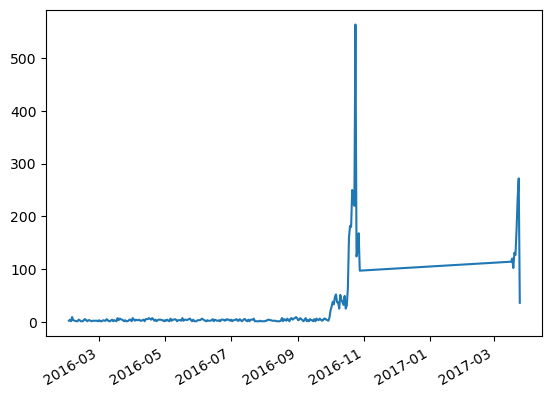

In [201]:
# 일별 거래 횟수를 계산하여 그래프로 출력
df_day = pd.to_datetime(df["create_date"].apply(lambda x: x[:10])).value_counts()
df_day.plot()
plt.show()

### [개별 피처 탐색하기: price 피처 탐색]

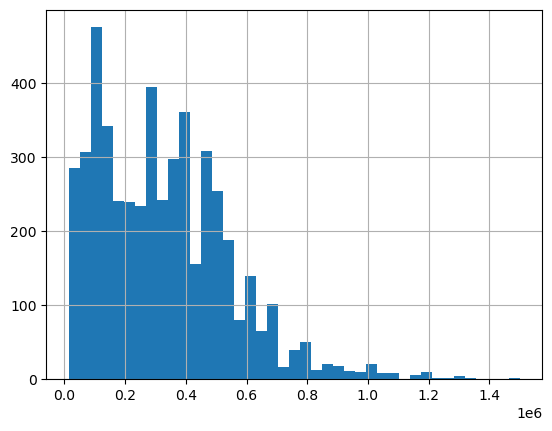

In [202]:
# 가격의 분포를 그래프로 탐색
df["price"].hist(bins = "auto")
plt.show()

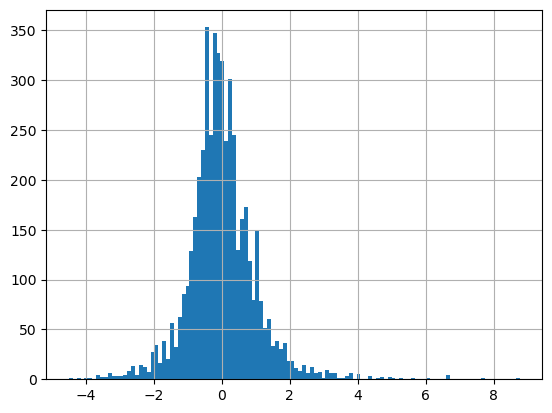

In [203]:
# 핸드폰 기종(phone_model)별 가격의 평균과 표준편차를 계산합니다.
df_price_model_mean = df.groupby("phone_model")["price"].transform(lambda x: np.mean(x))
df_price_model_std = df.groupby("phone_model")["price"].transform(lambda x: np.std(x))

# 이를 바탕으로 모든 데이터의 z-score를 계산합니다. 이는 해당 데이터의 가격이 기종별 평균에 비해 어느정도로 높거나 낮은지를 알 수 있게 하는 점수입니다.
df_price_model_z_score = (df["price"] - df_price_model_mean) / df_price_model_std
df_price_model_z_score.hist(bins = "auto")
plt.show()

### [개별 피처 탐색하기: factory_price 피처 탐색]

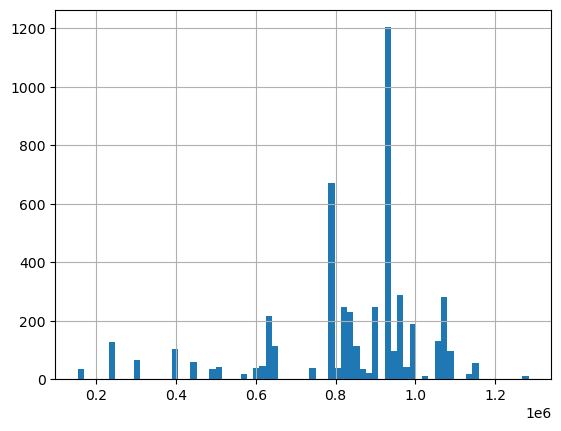

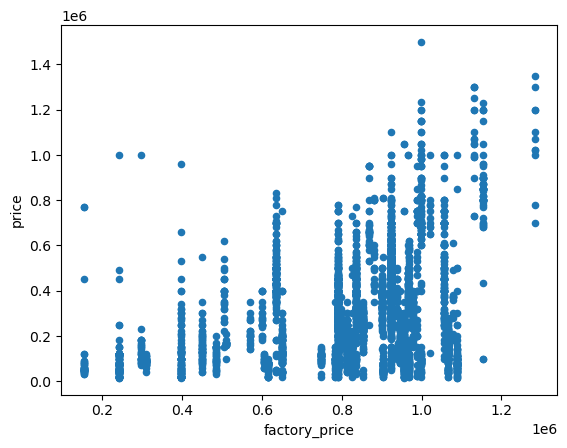

In [204]:
# factory_price 피처의 분포를 탐색
df["factory_price"].hist(bins = "auto")

# factory_price와 price 피처를 산점도 그래프로 출력하여 상관 관계를 살펴봄
df.plot.scatter("factory_price", "price")
plt.show()

### [개별 피처 탐색하기: phone_model 피처 탐색]

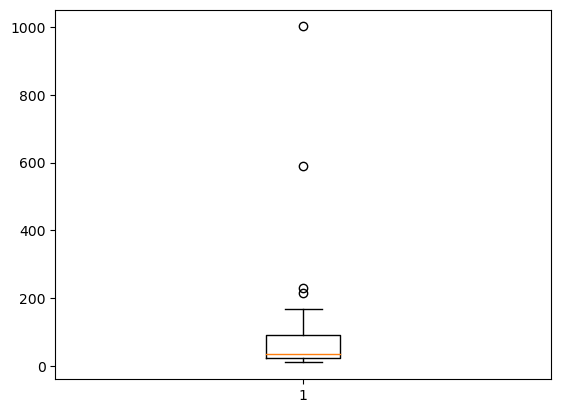

In [205]:
# 기종별 총 거래 데이터 개수를 집계
model_counts = df["phone_model"].value_counts()
model_counts.describe()

# 기종별 총 거래 데이터 개수를 상자 그림으로 살펴봄
plt.boxplot(model_counts)
plt.show()

#### 미니퀴즈

[maker, price_index 피처에 대한 특징을 탐색]

apple      2450
samsung    1642
lg          677
pantech      57
sony         37
huawei       35
tg           28
sky          25
Name: maker, dtype: int64


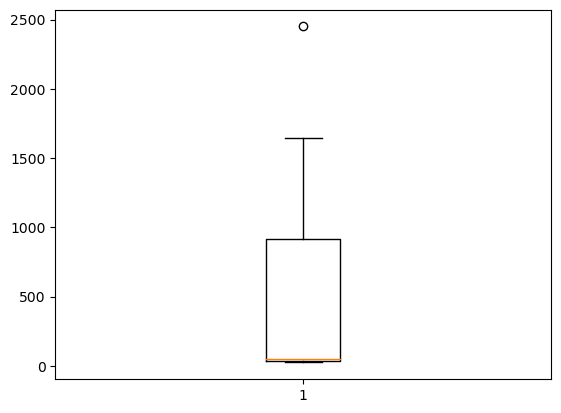

103.05000    3061
95.96000     1311
102.59000     448
94.90000      131
Name: price_index, dtype: int64


In [206]:
# maker 피처 탐색
maker_counts = df["maker"].value_counts()
print(maker_counts)
plt.boxplot(maker_counts)
plt.show()

# price_index 피처 탐색
price_index_counts = df["price_index"].value_counts()
print(price_index_counts)

### [Random forest regressor를 이용한 가격 예측]

In [207]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# 데이터를 학습/테스트용 데이터로 분리
df = df[["price", "phone_model", "factory_price", "maker", "price_index", "month"]]
df = pd.get_dummies(df, columns = ["phone_model", "maker", "month"])
x = df.loc[:, df.columns != "price"]
y = df["price"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

# 랜덤 포레스트 모델을 학습
forest = RandomForestRegressor(n_estimators = 1000, criterion = "squared_error")
forest.fit(x_train, y_train)
y_train_pred = forest.predict(x_train)
y_test_pred = forest.predict(x_test)

# 학습한 모델을 평가
print("MSE train: %.3f, test: %.3f" % (
      mean_squared_error(y_train, y_train_pred), # 실제값과 예측값 차이
      mean_squared_error(y_test, y_test_pred))) # 실제값과 예측값 차이
print("R^2 train: %.3f, test: %.3f" % (
      r2_score(y_train, y_train_pred), # 실제값과 예측값의 상관계수
      r2_score(y_test, y_test_pred))) # 실제값과 예측값의 상관계수

MSE train: 10621512965.571, test: 13860439875.786
R^2 train: 0.781, test: 0.683


### [피처 중요도 분석하기]

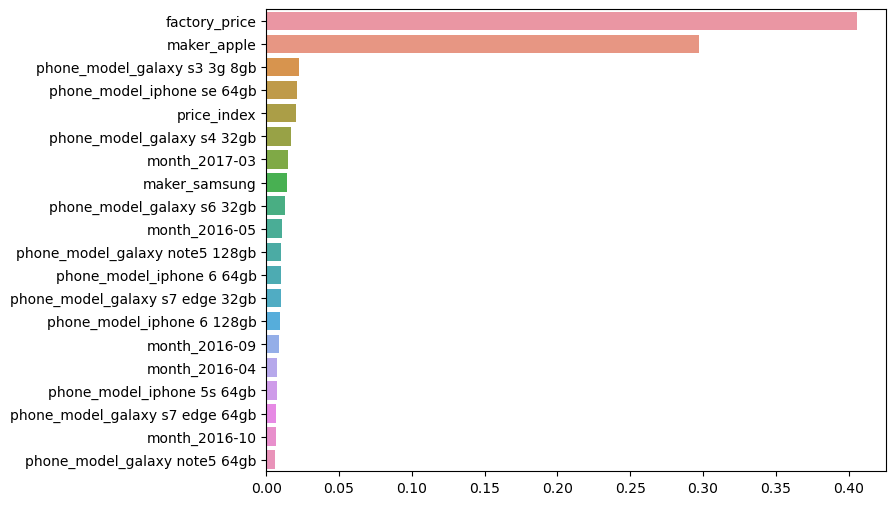

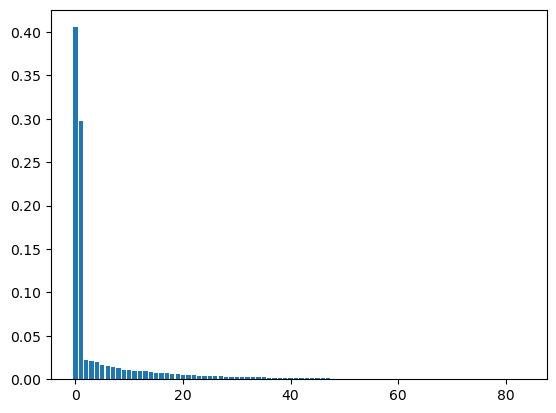

In [208]:
# 학습한 모델의 피처 중요도를 seaborn barplot 그래프로 살펴봄
importances = forest.feature_importances_
importances = pd.Series(importances, index = x_train.columns)
importances_top = importances.sort_values(ascending = False)[:20]

plt.figure(figsize = (8, 6))
sns.barplot(x = importances_top, y = importances_top.index)
plt.show()

# 학습한 모델의 피처 중요도를 matplotlib bar 그래프로 살펴봄
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(x = range(len(indices)), height = importances[indices])
plt.show()

In [209]:
# 학습한 모델의 피처 중요도를 출력
feat_labels = x.columns.tolist()
feature = list(zip(feat_labels, forest.feature_importances_))
sorted(feature, key = lambda x: x[1], reverse = True)[:10]

[('factory_price', 0.4055162747455254),
 ('maker_apple', 0.297357210011821),
 ('phone_model_galaxy s3 3g 8gb', 0.02230058755846541),
 ('phone_model_iphone se 64gb', 0.021470808556998105),
 ('price_index', 0.020152476293525606),
 ('phone_model_galaxy s4 32gb', 0.016788197891405156),
 ('month_2017-03', 0.014962554083370343),
 ('maker_samsung', 0.014528264923404975),
 ('phone_model_galaxy s6 32gb', 0.012564488881904498),
 ('month_2016-05', 0.01105571686051544)]

In [210]:
# month 피처 중, 영향력이 높은 순으로 정렬하여 출력
for sorted_feature in sorted(feature, key = lambda x: x[1],  reverse = True):
    if "month" in sorted_feature[0]:
        print(sorted_feature)

('month_2017-03', 0.014962554083370343)
('month_2016-05', 0.01105571686051544)
('month_2016-09', 0.008592337511287398)
('month_2016-04', 0.00748262912506)
('month_2016-10', 0.006422919293430515)
('month_2016-06', 0.0045159583064769545)
('month_2016-08', 0.0036764398838073486)
('month_2016-07', 0.0026831122727211283)
('month_2016-03', 0.002400373287862534)
('month_2016-02', 0.0011516771515964726)


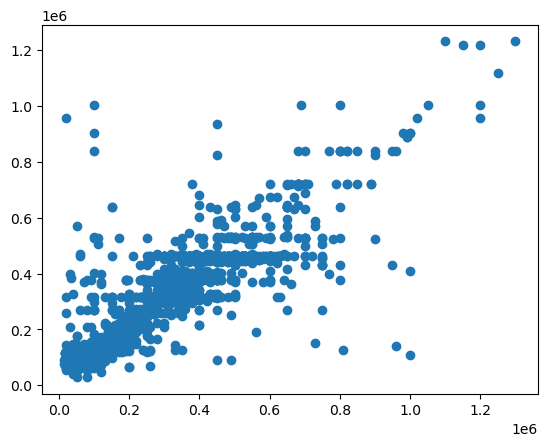

In [211]:
# 예측 결과
plt.scatter(y_test.values, y_test_pred)

## 피처 엔지니어링: 예측 모델 개선하기

### [기존 피처 가공하기: "create-date"]

In [212]:
# 데이터를 다시 불러옴
df = pd.read_csv("/Users/yanghaejun/Documents/이것이 데이터분석이다/이것이 데이터 분석이다 예제/data/used_mobile_phone.csv")
df

,create_date,price,text,phone_model,factory_price,maker,price_index
0,2017-03-19 4 35 00 PM,550000.00000,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96000
1,2016-10-26 12 08 00 PM,380000.00000,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05000
2,2016-10-25 12 52 00 PM,300000.00000,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05000
3,2017-03-23 11 14 00 PM,290000.00000,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96000
4,2016-04-11 7 35 00 PM,280000.00000,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59000
...,...,...,...,...,...,...,...
4946,2016-10-10 11 29 00 AM,1300000.00000,미개봉 언락폰 아이폰7플러스 256gb 골드 iphone7 plus 강북 도봉\t ...,iphone 7 plus 256gb,1283700,apple,103.05000
4947,2016-10-24 10 03 00 PM,1300000.00000,미국판 아이폰7 256g 제트블랙 강남역삼 2대 미개봉언락 애플 a1660 강남역삼...,iphone 7 256gb,1130800,apple,103.05000
4948,2016-09-19 10 15 00 AM,1300000.00000,"아이폰7 미개봉 홍콩판 팝니다 케이스,강화유리서비스 종류다양 아이폰7 917,91...",iphone 7 256gb,1130800,apple,103.05000
4949,2016-10-05 12 22 00 AM,1350000.00000,미개봉 언락폰 아이폰7플러스 256gb 골드 iphone7 plus 강북 도봉 미개...,iphone 7 plus 256gb,1283700,apple,103.05000


In [213]:
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import time

# create_date 피처를 수치적으로 계산하기 위해, unixtime으로 변환하는 함수를 정의
def date_to_unixtime(date_str):
    timestamp = time.mktime(datetime.strptime(date_str, "%Y-%m-%d").timetuple())
    return timestamp

# create_date 피처를 '현재와 얼마나 가까운 데이터인 지' 판단하기 위한 점수를 생성. 먼저 unixtime으로 데이터를 변환
df["create_unixtime"] = df["create_date"].apply(lambda x: date_to_unixtime(x[:10]))

# 변환된 unixtime에 min-max 스케일링을 적용
df["create_time_score"] = (df["create_unixtime"] - df["create_unixtime"].min()) / (df["create_unixtime"].max() - df["create_unixtime"].min())
df

,create_date,price,text,phone_model,factory_price,maker,price_index,create_unixtime,create_time_score
0,2017-03-19 4 35 00 PM,550000.00000,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96000,1489849200.00000,0.98561
1,2016-10-26 12 08 00 PM,380000.00000,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05000,1477407600.00000,0.64029
2,2016-10-25 12 52 00 PM,300000.00000,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05000,1477321200.00000,0.63789
3,2017-03-23 11 14 00 PM,290000.00000,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96000,1490194800.00000,0.99520
4,2016-04-11 7 35 00 PM,280000.00000,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59000,1460300400.00000,0.16547
...,...,...,...,...,...,...,...,...,...
4946,2016-10-10 11 29 00 AM,1300000.00000,미개봉 언락폰 아이폰7플러스 256gb 골드 iphone7 plus 강북 도봉\t ...,iphone 7 plus 256gb,1283700,apple,103.05000,1476025200.00000,0.60192
4947,2016-10-24 10 03 00 PM,1300000.00000,미국판 아이폰7 256g 제트블랙 강남역삼 2대 미개봉언락 애플 a1660 강남역삼...,iphone 7 256gb,1130800,apple,103.05000,1477234800.00000,0.63549
4948,2016-09-19 10 15 00 AM,1300000.00000,"아이폰7 미개봉 홍콩판 팝니다 케이스,강화유리서비스 종류다양 아이폰7 917,91...",iphone 7 256gb,1130800,apple,103.05000,1474210800.00000,0.55156
4949,2016-10-05 12 22 00 AM,1350000.00000,미개봉 언락폰 아이폰7플러스 256gb 골드 iphone7 plus 강북 도봉 미개...,iphone 7 plus 256gb,1283700,apple,103.05000,1475593200.00000,0.58993


### [기존 피처의 가공: phone_model]

In [214]:
# phone_model 피처에서 저장 용량(phone_model_storage) 피처를 추출
df["phone_model_storage"] = df["phone_model"].apply(lambda x: x.split(" ")[-1])

# phone_model 피처에서 기종 세부명(phone_model_detail) 피처를 추출
df["phone_model_detail"] = df["phone_model"].apply(lambda x: " ".join(x.split(" ")[:-1]))
df

,create_date,price,text,phone_model,factory_price,maker,price_index,create_unixtime,create_time_score,phone_model_storage,phone_model_detail
0,2017-03-19 4 35 00 PM,550000.00000,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96000,1489849200.00000,0.98561,64gb,iphone 6
1,2016-10-26 12 08 00 PM,380000.00000,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05000,1477407600.00000,0.64029,32gb,galaxy s6 edge
2,2016-10-25 12 52 00 PM,300000.00000,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05000,1477321200.00000,0.63789,32gb,galaxy s6
3,2017-03-23 11 14 00 PM,290000.00000,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96000,1490194800.00000,0.99520,32gb,lg g5
4,2016-04-11 7 35 00 PM,280000.00000,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59000,1460300400.00000,0.16547,32gb,lg u
...,...,...,...,...,...,...,...,...,...,...,...
4946,2016-10-10 11 29 00 AM,1300000.00000,미개봉 언락폰 아이폰7플러스 256gb 골드 iphone7 plus 강북 도봉\t ...,iphone 7 plus 256gb,1283700,apple,103.05000,1476025200.00000,0.60192,256gb,iphone 7 plus
4947,2016-10-24 10 03 00 PM,1300000.00000,미국판 아이폰7 256g 제트블랙 강남역삼 2대 미개봉언락 애플 a1660 강남역삼...,iphone 7 256gb,1130800,apple,103.05000,1477234800.00000,0.63549,256gb,iphone 7
4948,2016-09-19 10 15 00 AM,1300000.00000,"아이폰7 미개봉 홍콩판 팝니다 케이스,강화유리서비스 종류다양 아이폰7 917,91...",iphone 7 256gb,1130800,apple,103.05000,1474210800.00000,0.55156,256gb,iphone 7
4949,2016-10-05 12 22 00 AM,1350000.00000,미개봉 언락폰 아이폰7플러스 256gb 골드 iphone7 plus 강북 도봉 미개...,iphone 7 plus 256gb,1283700,apple,103.05000,1475593200.00000,0.58993,256gb,iphone 7 plus


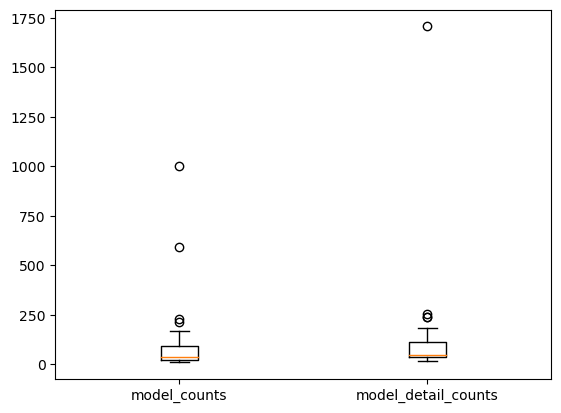

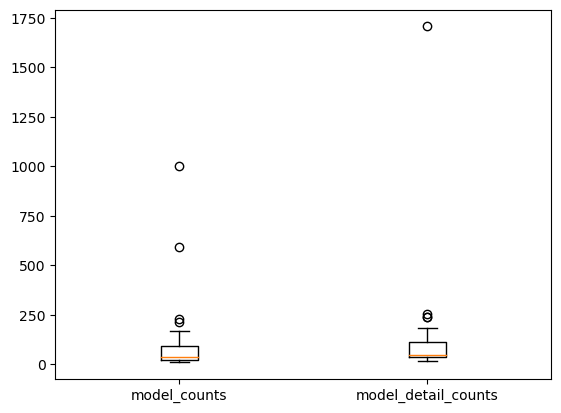

In [215]:
# phone_model 피처의 기종별 거래 데이터 개수를 집계
model_counts = df["phone_model"].value_counts()

# phone_model_detail 피처의 기종별 거래 데이터 개수를 집계
model_detail_counts = df["phone_model_detail"].value_counts()
data = [model_counts, model_detail_counts]

# 두 피처 간의 기종별 거래 데이터 개수를 비교(상태기반)
plt.boxplot(data)
plt.xticks(np.arange(1, 3), ["model_counts", "model_detail_counts"])

# 객체기반
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(data)
ax.set_xticklabels(["model_counts", "model_detail_counts"])
plt.show()

### [phone_model 관련 딕셔너리 생성]

In [216]:
# 모델명 +  용량으로 출고가를 찾을 수 있는 딕셔너리를 생성
model_to_factory_price_dict = {}
for index, row in df.iterrows():
    model_concat = (row["phone_model_detail"], row["phone_model_storage"])
    if model_concat in model_to_factory_price_dict:
        pass
    else:
        model_to_factory_price_dict[model_concat] = row["factory_price"]
print(str(model_to_factory_price_dict)[:100] + "...")

{('iphone 6', '64gb'): 924000, ('galaxy s6 edge', '32gb'): 979000, ('galaxy s6', '32gb'): 854000, ('...


### [감성 분류 물품의 상태 분류하기]

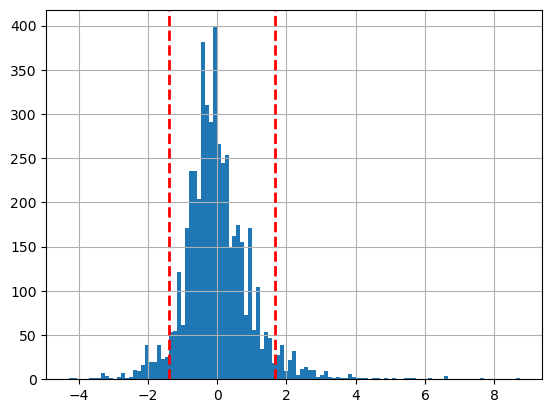

-1.3966616903783375 1.666982156397844


In [217]:
# 거래 가격(price)의 z-score를 계산. 이는 해당 데이터의 가격이 기종의 평균에 비해 어느 정도로 높거나 낮은지를 알 수 있게 하는 점수
df["price_by_group"] = df.groupby("phone_model_detail")["price"].transform(lambda x: (x - x.mean()) / x.std())

# 거래 가격의 z-score(price_by_group) 의 분포를 그래프로 츨력
ax = df["price_by_group"].hist(bins = "auto")

# z-score(price_by_group) 기준으로 하위 5%, 상위 5%에 해당하는 점수를 lower_bound, upper_bound라고 지정
lower_bound = df["price_by_group"].quantile(0.05)
upper_bound = df["price_by_group"].quantile(0.95)

# lower_bound, upper_bound 그래프에 추가
ax.axvline(x = lower_bound, color = "r", linestyle = "dashed", linewidth = 2)
ax.axvline(x = upper_bound, color = "r", linestyle = "dashed", linewidth = 2)
plt.show()

# lower_bound, upper_bound 출력
print(lower_bound, upper_bound)

In [218]:
# lower_bound보다 낮으면 0, upper_bound보다 높으면 2, 그 중간이면 1로 가격의 상태를 분류하는 함수를 정의
def get_price_level(price, lower, upper):
    if price <= lower:
        return "0"
    elif price >= upper:
        return "2"
    else:
        return "1"
    
# lower_bound보다 낮으면 0, upper_bound보다 높으면 2, 그 중간이면 1로 가격의 상태를 분류
df["price_lower"] = df.groupby("phone_model_detail")["price"].transform(lambda x: x.quantile(0.05))
df["price_upper"] = df.groupby("phone_model_detail")["price"].transform(lambda x: x.quantile(0.95))
df["price_level"] = df.apply(lambda row: get_price_level(row["price"], row["price_lower"], row["price_upper"]), axis = 1)
df[["price", "price_lower", "price_upper", "price_level", "text"]]

,price,price_lower,price_upper,price_level,text
0,550000.00000,180000.00000,680000.00000,1,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...
1,380000.00000,180000.00000,414000.00000,1,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...
2,300000.00000,150000.00000,349000.00000,1,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...
3,290000.00000,100000.00000,500000.00000,1,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...
4,280000.00000,18000.00000,400000.00000,1,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...
...,...,...,...,...,...
4946,1300000.00000,628200.00000,1200000.00000,2,미개봉 언락폰 아이폰7플러스 256gb 골드 iphone7 plus 강북 도봉\t ...
4947,1300000.00000,597000.00000,1200000.00000,2,미국판 아이폰7 256g 제트블랙 강남역삼 2대 미개봉언락 애플 a1660 강남역삼...
4948,1300000.00000,597000.00000,1200000.00000,2,"아이폰7 미개봉 홍콩판 팝니다 케이스,강화유리서비스 종류다양 아이폰7 917,91..."
4949,1350000.00000,628200.00000,1200000.00000,2,미개봉 언락폰 아이폰7플러스 256gb 골드 iphone7 plus 강북 도봉 미개...


### [텍스트 전처리하기]

In [219]:
import pickle
import re

# 중고나라 불용어 사전을 불러옴
with open("/Users/yanghaejun/Documents/이것이 데이터분석이다/이것이 데이터 분석이다 예제/data/used_mobile_phone_stopwords.pkl", "rb") as f:
    stopwords = pickle.load(f)

# 불용어 사전에 등록된 단어 10개를 출력
stopwords[:10]

['거래', '입니', '판매', '아이폰', '갤럭시', '골드', '팝', '만원', '폰', '시']

### [형태소 단위로 추출하기]

In [220]:
from konlpy.tag import Okt

# "+"를 제외한 특수문자를 제거하고, 숫자 형태의 문자를 제거
def text_cleaning(text):
    text = "".join(c for c in text if c.isalnum() or c in "+, ")
    text = "".join(i for i in text if i.isdigit() == False)
    return text

# 불용어에 등장하지 않는 형태소만을 추출하여 반환하는 함수
def get_pos(x):
    tagger = Okt()
    poses = tagger.pos(x)
    return [pos[0] for pos in poses if pos[0] not in stopwords]

# 위 함수들을 적용한 형태소 추출을 테스트
df["text"] = df["text"].apply(lambda x: text_cleaning(x))
result = get_pos(df["text"][0])
print(result)

['+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '리퍼', '기간', '만료', '되어서', '징', '하게', '되었습니다', '상태', '초', 'a', '급', '스', '없습니다', '+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '리퍼', '기간', '만료', '되어서', '징', '하게', '되었습니다', '상태', '초', 'a', '급', '스', '없습니다', '징', '애플', '라이트', '홈', '버튼', '링', '카메라', '링', '볼륨', '버튼', '슬립', '버튼', '검금', '심플', '튀지', '않게', '이쁘게', '했구요', '유심', '꽂고', '바로', '사용', '하시면', '됩니다', '사람', '이냐', '자주', '물어보고', '실제', '더욱', '이쁩니다', '밤', '영롱하게', '맥북', '뒷', '사과', '로고', '비춰지고', '요전', '넘어가기', '위해', '합니다', '가능합니다', '박스', '어머니', '버리시고', '이어폰', '충전기', '정품', '드립니다', '직거래', '우선', '순', '위로', '정', '싶으시면', '선', '입금', '택배', '발송', '해드리겠습니다', '믿으시면', '직거래', '하시길', '추천', '해요', '안전', '합니다', '서울시', '강남구', '역삼동', '차병원', '사거리', '근처', '가격']


### [빈출 형태소 2500개 선정하기]

In [221]:
from collections import Counter

# get_pos 함수를 모든 텍스트 데이터에 적용하여 형태소 말뭉치를 추출
corpus = sum(df["text"].apply(lambda x: get_pos(x)).tolist(), [])

# 추출된 형태소 말뭉치에서 가장 많이 등장한 형태소 2500개를 추출
counter = Counter(corpus)
common_words = [key for key, _ in counter.most_common(2500)]
common_words

['입니다',
 '직거래',
 's',
 '합니다',
 '택배',
 '사용',
 '급',
 '상태',
 '팝니다',
 '가능합니다',
 '정상',
 '사진',
 '가격',
 '+',
 '케이스',
 'a',
 '주세요',
 '해지',
 '삭제',
 '제품',
 '있습니다',
 '박스',
 '가능',
 '직접',
 '액정',
 '배터리',
 '성품',
 '필름',
 '리퍼',
 '충전기',
 '없습니다',
 '풀',
 '개통',
 '유심',
 '즈',
 '안전',
 '스',
 '하기',
 '신청',
 '드립니다',
 '통신사',
 '구입',
 '약정',
 '이어폰',
 '공기',
 '새',
 '기변',
 '포함',
 '모델',
 '선택',
 '됩니다',
 '확인',
 '기간',
 '기스',
 '그레이',
 '찍힘',
 '방법',
 '바로',
 '할인',
 '제',
 '시기',
 '스페이스',
 '희망',
 '번호',
 '중고나라',
 '본체',
 '같이',
 '생활',
 '잘',
 '무',
 '퀵',
 '글',
 '된',
 '않을',
 '공식',
 '앱',
 '확정',
 '기능',
 '다운',
 '양',
 '호환',
 '케이블',
 '받기',
 '미',
 '이메일',
 '작성',
 '부분',
 '금지',
 '될수',
 '식아이디',
 '허위',
 '임의',
 '통보',
 '채우지',
 '핸드폰',
 '편한',
 '전혀',
 '충전',
 '내용',
 '연락처',
 '단말기',
 '부산',
 '대구',
 '미사',
 '정품',
 '중고',
 '문제',
 '없이',
 '이상',
 '보호',
 '방문',
 '없는',
 '외관',
 '외',
 '인천',
 '깨끗합니다',
 'x',
 '초기',
 '하나',
 '참고',
 '이구',
 '요금',
 '개월',
 '이나',
 '사이트',
 '팔아요',
 '하시면',
 '했습니다',
 '동',
 '카페',
 '보내',
 '카톡',
 '블로그',
 '링크',
 '싸이',
 '강퇴',
 '삼성',
 '거치',
 '있는',
 '호선'

### [TF-IDF 벡터 생성하기]

In [222]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# 빈출 형태소를 제외한 모든 형태소를 제거하는 함수를 정의
def get_common_pos(x):
    tagger = Okt()
    poses = tagger.pos(x)
    return [pos[0] for pos in poses if pos[0] in common_words]

# 1:3:1 비율로 랜덤 샘플링을 수행
negative_random = df[df["price_level"] == "0"].sample(321, random_state = 30)
neutral_random = df[df["price_level"] == "1"].sample(321*3, random_state = 30)
positive_random = df[df["price_level"] == "2"].sample(321, random_state = 30)

# 샘플링 완료된 데이터셋을 정의
df_sample = negative_random.append(neutral_random).append(positive_random)

# TF-IDF를 수행하여 피처를 변환
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_common_pos(x))
x = index_vectorizer.fit_transform(df_sample["text"].tolist())
tfidf_vetorizer = TfidfTransformer()
x = tfidf_vetorizer.fit_transform(x)

# 감성 분류를 위한 학습 데이터셋을 정의
y = df_sample["price_level"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 30)
print(x_train.shape)
print(x_test.shape)

/var/folders/79/v97_0rqs3p34z9xx6y57xks80000gn/T/ipykernel_1771/3571288690.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sample = negative_random.append(neutral_random).append(positive_random)
/var/folders/79/v97_0rqs3p34z9xx6y57xks80000gn/T/ipykernel_1771/3571288690.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sample = negative_random.append(neutral_random).append(positive_random)
/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(1284, 2476)
(321, 2476)


### [상품 상태 분류하기]

In [223]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC

# 비선형 SVM분류 모델을 학습하고 평가
svm = SVC(kernel = "rbf", gamma = 0.10, C = 10.0, random_state = 0)
svm.fit(x_train, y_train)
y_pred_ksvc = svm.predict(x_test)
print("Accuray: %.2f" % accuracy_score(y_test, y_pred_ksvc))

# Confusion Matrix를 출력
confmat = confusion_matrix(y_test, y_pred_ksvc)
print(confmat)

Accuray: 0.77
[[ 30  28   4]
 [ 10 181  10]
 [  2  21  35]]


### [Random forest regressor 재학습하기]

In [224]:
df.to_csv("/Users/yanghaejun/Documents/이것이 데이터분석이다/이것이 데이터 분석이다 예제/data/used_mobile_phone_data.csv")

In [225]:
# text 피처로부터 '상품 상태 피처(product_status)'를 생성
x = index_vectorizer.transform(df["text"].tolist())
x = tfidf_vetorizer.transform(x)
df["product_status"] = pd.Series(svm.predict(x))

# 랜덤 포레스트 모델을 학습을 위한 데이터를 준비
df = df[["price", "factory_price", "maker", "price_index", "create_time_score", "phone_model_storage", "phone_model_detail", "product_status"]]
df = pd.get_dummies(df, columns = ["maker", "phone_model_storage", "phone_model_detail", "product_status"])

# 학습/테스트 데이터를 분리
x = df.loc[:, df.columns != "price"]
y = df["price"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

# 랜덤포레스트 모델을 학습하고 평가
forest = RandomForestRegressor(n_estimators = 1000, criterion = "squared_error")
forest.fit(x_train, y_train)
y_train_pred = forest.predict(x_train)
y_test_pred = forest.predict(x_test)
print("MSE train: %.3f, test: %.3f" % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print("R^2 train: %.3f, test: %.3f" % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train: 4788421769.428, test: 11021537717.250
R^2 train: 0.901, test: 0.748


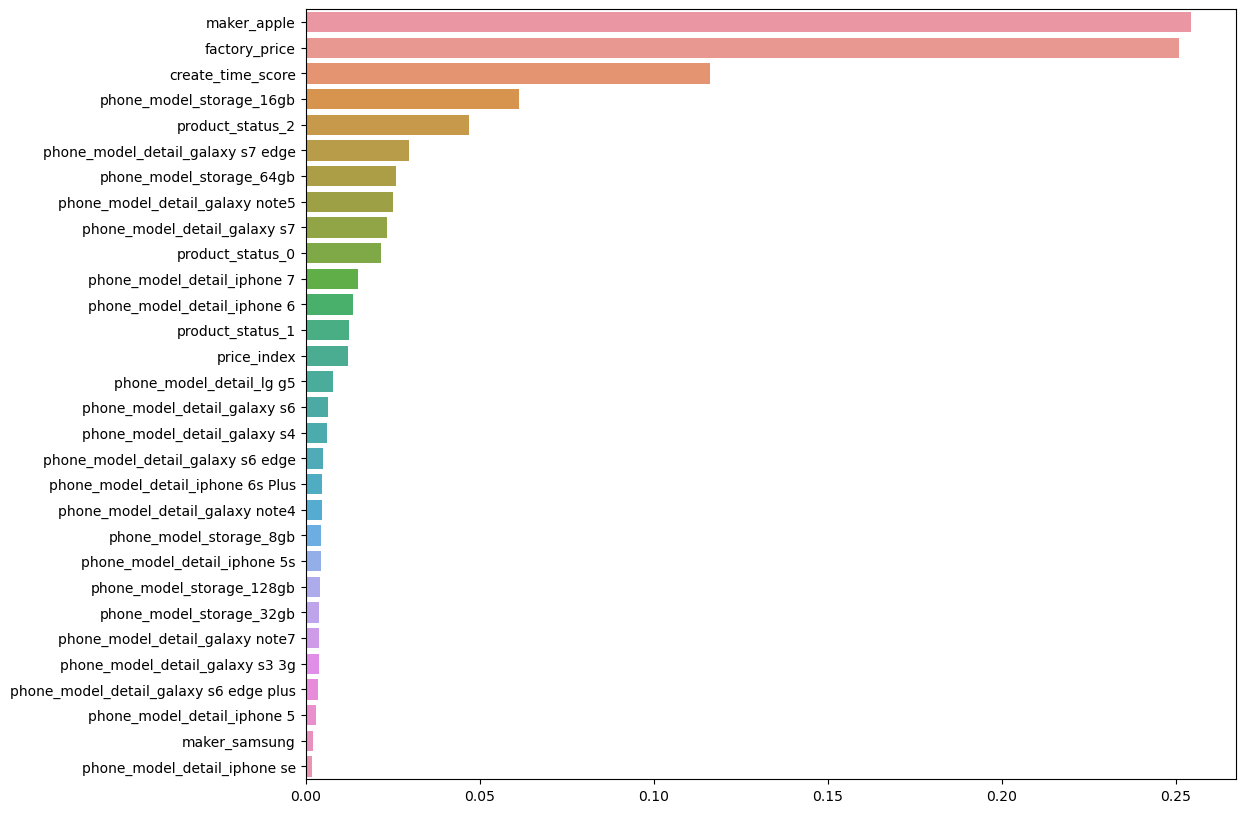

[('maker_apple', 0.254446256890298),
 ('factory_price', 0.25081918524353986),
 ('create_time_score', 0.1161975550494664),
 ('phone_model_storage_16gb', 0.06136850199092137),
 ('product_status_2', 0.04685047016431196),
 ('phone_model_detail_galaxy s7 edge', 0.029703272625415368),
 ('phone_model_storage_64gb', 0.02584351191923547),
 ('phone_model_detail_galaxy note5', 0.025229783939706586),
 ('phone_model_detail_galaxy s7', 0.023480358122371467),
 ('product_status_0', 0.021618245659521442)]

In [226]:
# 피처 중요도 plot을 출력
importances = forest.feature_importances_
importances = pd.Series(importances, index = x_train.columns)
importances_top = importances.sort_values(ascending = False)[:30]

plt.figure(figsize = (12, 10))
sns.barplot(x = importances_top, y = importances_top.index)
plt.show()

# 피처 중요도를 출력
feat_labels = x.columns.tolist()
feature = list(zip(feat_labels, importances))
sorted(feature, key = lambda x: x[1], reverse = True)[:10]

### [feature-index 관련 딕셔너리 생성]

In [227]:
# 프로그램에서 입력값에 대한 피처를 찾기 위한 딕셔너리를 생성
col_to_index_dict = {}
for idx, col in enumerate(df.columns[1:]):
    col_to_index_dict[col] = idx

print(str(col_to_index_dict)[:100], "...")

{'factory_price': 0, 'price_index': 1, 'create_time_score': 2, 'maker_apple': 3, 'maker_huawei': 4,  ...


### [예측 결과 산점도 그래프]

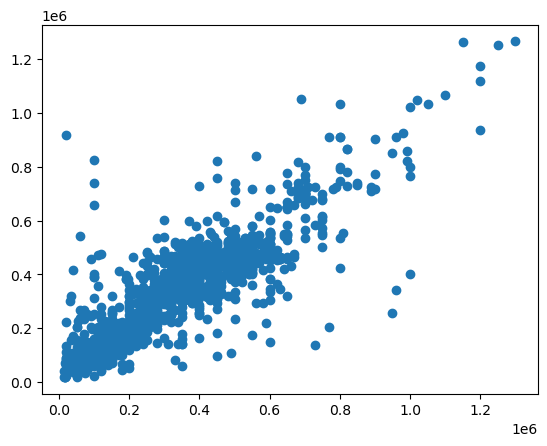

In [228]:
# 테스트 데이터의 y값과 예측된 y값을 산점도 그래프를 활용하여 상관 관계를 살펴봄
plt.scatter(y_test, y_test_pred)

### [최적의 모델 파라미터 찾기]

In [229]:
from sklearn.model_selection import RandomizedSearchCV

# Randomized Search로 찾아낼 파라미터 후보군을 각각 리스트로 선정
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] # 사용할 트리의 수
max_features = ["auto", "sqrt"] # 무작위로 선택한 피처의 수
max_depth = [int(x) for x in np.linspace(start = 10, stop = 110, num = 11)] # 트리의 깊이
max_depth.append(None)
bootstrap = [True, False] # True: 전체 피처에서 복원 추출로 트리를 만듦, False: 전체 피처에서 비복원 추출로 트리를 만듦

# RandomizedSearchCV 오브젝트를 생성하여 모델을 정의
random_grid = {"n_estimators": n_estimators,
               "max_features": max_features,
               "max_depth": max_depth,
               "bootstrap": bootstrap}
forest = RandomForestRegressor()
optimal_forest = RandomizedSearchCV(estimator = forest,
                                    param_distributions = random_grid, # 파라미터 입력
                                    n_iter = 100, # 파라미터 검색 횟수
                                    cv = 3, # 교차검증 시 fold 개수
                                    verbose = 1, # 진행상황(1: 생략, 2: 다 보여줌)
                                    random_state = 42,
                                    n_jobs = -1) # 사용할 CPU 코어 개수(1: 기본값, -1: 모든 코어 다 사용) 

# RandomizedSearchCV 모델을 학습
x = df.loc[:, df.columns != "price"]
y = df["price"]
optimal_forest.fit(x, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, n_estimators=800; total time=   7.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, n_estimators=800; total time=   7.8s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, n_estimators=800; total time=   8.2s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, n_estimators=1000; total time=  10.6s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, n_estimators=1000; total time=  10.5s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, n_estimators=1000; total time=  11.8s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, n_estimators=1000; total time=  11.6s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, n_estimators=1000; total time=  11.7s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, n_estimators=600; total time=   5.2s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, n_estimators=

/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=sqrt, n_estimators=1600; total time=  15.4s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, n_estimators=600; total time=   5.4s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=sqrt, n_estimators=1600; total time=  16.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, n_estimators=1600; total time=  16.1s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, n_estimators=2000; total time=  19.6s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, n_estimators=2000; total time=  21.9s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, n_estimators=2000; total time=  22.2s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, n_estimators=1200; total time=  11.0s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, n_estimators=1200; total time=  12.2s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, n_estimators=1200; total time=  11.5s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, n_estimators=1600; total time=  11.1s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, n_estimators=1600; total time=  12.8s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, n_estimators=1600; total time=  12.6s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=auto, n_estimators=600; total time=  14.1s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=auto, n_estimators=600; total time=  15.4s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, n_estimators=1800; total time=  38.0s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, n_estimators=1800; total time=  39.2s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=auto, n_estimators=600; total time=  18.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, n_estimators=1800; total time=  42.3s
[CV] END bootstrap=False, max_depth=30, max_features=auto, n_estimators=400; total time=   9.1s
[CV] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=2000; total time=  20.9s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, n_estimators=800; total time=   6.9s
[CV] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=2000; total time=  21.8s
[CV] END bootstrap=False, max_depth=30, max_features=auto, n_estimators=400; total time=   9.5s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, n_estimators=200; total time=   1.7s
[CV] END bootstrap=False, max_depth=30, max_features=auto, n_estimators=400; total time=  11.5s
[CV] END bootstrap=False, max_depth=100

/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, n_estimators=1800; total time=  15.6s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, n_estimators=1200; total time=   8.6s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, n_estimators=1200; total time=   9.6s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, n_estimators=1800; total time=  17.7s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, n_estimators=1800; total time=  17.6s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, n_estimators=800; total time=   5.2s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, n_estimators=1200; total time=   9.4s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, n_estimators=800; total time=   5.8s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, n_estimators=800; total time=   5.6s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=auto, n_estimators=200; total time=   3.3s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=auto, n_estimators=200; total time=   3.7s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=auto, n_estimators=200; total time=   4.1s
[CV] END bootstrap=False, max_depth=100, max_features=auto, n_estimators=800; total time=  18.3s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, n_estimators=800; total time=  12.7s
[CV] END bootstrap=False, max_depth=100, max_features=auto, n_estimators=800; total time=  19.8s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, n_estimators=200; total time=   1.4s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, n_estimators=200; total time=   1.6s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, n_estimators=800; total time=  14.7s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, n_estimators=200; total time=   1.6s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, n_estimators=800; total time=  16.7s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=auto, n_estimators=800; total time=  24.2s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, n_estimators=400; total time=   8.5s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, n_estimators=400; total time=   8.7s
[CV] END bootstrap=False, max_depth=20, max_features=auto, n_estimators=400; total time=   9.7s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=1000; total time=   9.0s
[CV] END bootstrap=True, max_depth=60, max_features=auto, n_estimators=1000; total time=  16.7s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=1000; total time=  10.3s
[CV] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=1200; total time=  28.4s
[CV] END bootstrap=True, max_depth=60, max_features=auto, n_estimators=1000; total time=  18.6s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=1200; total time=  30.8s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=1000; total time=   9.6s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=auto, n_estimators=1000; total time=  20.5s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, n_estimators=400; total time=   9.0s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=1200; total time=  36.7s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, n_estimators=1800; total time=  15.3s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, n_estimators=400; total time=   9.8s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=200; total time=   2.1s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=auto, n_estimators=400; total time=   9.2s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, n_estimators=1800; total time=  17.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=200; total time=   2.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, n_estimators=200; total time=   2.3s
[CV] END bootstrap=False, max_depth=50, max_features=auto, n_estimators=400; total time=  11.9s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, n_estimators=1800; total time=  17.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=400; total time=   1.7s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, n_estimators=400; total time=   3.4s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=400; total time=   1.8s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=400; total time=   2.0s
[CV] END bootstrap=False, max_depth=40, max_features=auto, n_estimators=400; total time=   9.8s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, n_estimators=400; total time=   3.7s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, n_estimators=400; total time=   3.7s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, n_estimators=200; total time=   1.8s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, n_estimators=200; total time=   1.9s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, n_estimators=200; total time=   2.0s
[CV] END bootstrap=False, max_depth=40, max_features=auto, n_estimators=400; total time=  11.7s
[CV] END bootstrap=False, max_depth=80, max_features=auto, n_estimators=200; total time=   4.6s
[CV] END bootstrap=False, max_depth=80, max_features=auto, n_estimators=200; total time=   5.0s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=auto, n_estimators=200; total time=   6.1s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, n_estimators=1600; total time=  11.5s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, n_estimators=1600; total time=  14.0s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, n_estimators=1600; total time=  12.8s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, n_estimators=1600; total time=  13.2s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, n_estimators=1600; total time=  15.5s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, n_estimators=1600; total time=  16.1s
[CV] END bootstrap=False, max_depth=40, max_features=auto, n_estimators=600; total time=  14.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=400; total time=   3.5s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, n_estimators=800; total time=   6.2s
[CV] END bootstrap=False, max_depth=40, max_features=auto, n_estimators=600; total time=  15.4s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=400; total time=   3.9s
[CV] END bootstrap=True, max_depth

/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, n_estimators=600; total time=   5.0s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, n_estimators=600; total time=   5.7s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, n_estimators=600; total time=   5.8s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=1800; total time=   7.8s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=1800; total time=   8.3s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, n_estimators=200; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=1800; total time=   8.4s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, n_estimators=200; total time=   1.6s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, n_estimators=200; total time=   1.5s
[CV] END bootstrap=False, max_depth=40, max_features=auto, n_estimators=600; total time=  17.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=200; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=200; total time=   3.6s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=200; total time=   3.9s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=auto, n_estimators=1200; total time=  19.3s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, n_estimators=2000; total time=  13.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, n_estimators=2000; total time=  14.8s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, n_estimators=2000; total time=  14.3s
[CV] END bootstrap=True, max_depth=100, max_features=auto, n_estimators=1200; total time=  21.5s
[CV] END bootstrap=False, max_depth=50, max_features=auto, n_estimators=800; total time=  18.5s
[CV] END bootstrap=True, max_depth=100, max_features=auto, n_estimators=1200; total time=  24.7s
[CV] END bootstrap=False, max_depth=50, max_features=auto, n_estimators=800; total time=  20.2s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, n_estimators=1400; total time=   9.9s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, n_estimators=2000; total time=  17.5s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, n_estimators=1400; total time=  11.2s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, n_estimators=1200; total time=   8.7s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, n_estimators=1400; total time=  11.3s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=110, max_features=sqrt, n_estimators=2000; total time=  20.2s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, n_estimators=2000; total time=  20.1s
[CV] END bootstrap=False, max_depth=50, max_features=auto, n_estimators=800; total time=  24.4s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, n_estimators=1200; total time=  10.1s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, n_estimators=200; total time=   1.8s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, n_estimators=200; total time=   1.9s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, n_estimators=200; total time=   1.9s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, n_estimators=1200; total time=   9.9s
[CV] END bootstrap=False, max_depth=60, max_features=auto, n_estimators=200; total time=   4.6s
[CV] END bootstrap=False, max_depth=60, max_features=auto, n_estimators=200; total time=   5.0s
[CV] END bootstrap=False, max_depth=60, max_features=auto, n_estimators=200; total time=   5.9s
[CV] END bootstrap=True, max_depth=40, max_features=auto, n_estimators=800; total time=  12.8s
[CV] END bootstrap=True, max_depth=40, max_features=auto, n_estimators=800; total time=  14.7s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, n_estimators=1200; total time=  10.1s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, n_estimators=800; total time=  16.2s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, n_estimators=1000; total time=   8.4s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, n_estimators=1200; total time=  11.8s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, n_estimators=1200; total time=  11.5s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, n_estimators=1000; total time=   9.7s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, n_estimators=1000; total time=   9.8s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, n_estimators=600; total time=   9.6s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, n_estimators=600; total time=  11.2s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=auto, n_estimators=400; total time=   6.7s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=auto, n_estimators=1200; total time=  28.9s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, n_estimators=600; total time=  13.5s
[CV] END bootstrap=False, max_depth=40, max_features=auto, n_estimators=1200; total time=  32.0s
[CV] END bootstrap=True, max_depth=60, max_features=auto, n_estimators=400; total time=   8.7s
[CV] END bootstrap=False, max_depth=20, max_features=auto, n_estimators=1400; total time=  31.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, n_estimators=1400; total time=  32.2s
[CV] END bootstrap=True, max_depth=60, max_features=auto, n_estimators=400; total time=   9.6s
[CV] END bootstrap=False, max_depth=40, max_features=auto, n_estimators=1200; total time=  38.3s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, n_estimators=800; total time=   6.4s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, n_estimators=1400; total time=  36.1s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, n_estimators=800; total time=   7.6s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, n_estimators=800; total time=   6.9s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=1600; total time=  16.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, n_estimators=800; total time=   4.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, n_estimators=800; total time=   4.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, n_estimators=800; total time=   4.6s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=1600; total time=  16.8s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=1600; total time=  18.1s
[CV] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=800; total time=  19.3s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, n_estimators=1800; total time=  12.5s
[CV] END bootstrap=False, max_d

/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, n_estimators=1800; total time=  13.6s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, n_estimators=1800; total time=  13.3s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=800; total time=  23.1s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=1000; total time=   5.5s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=1000; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=1000; total time=   5.9s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, n_estimators=1600; total time=   9.7s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, n_estimators=600; total time=   8.8s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, n_estimators=600; total time=   9.1s
[CV] END bootstrap=False, max_depth=40, max_features=auto, n_estimators=1000; total time=  14.7s
[CV] END bootstrap=False, max_depth=50, max_features=auto, n_estimators=600; total time=  10.7s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, n_estimators=600; total time=   2.5s
[CV] END bootstrap=False, max_depth=40, max_features=auto, n_estimators=1000; total time=  15.5s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, n_estimators=600; total time=   2.6s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, n_estimators=600; total time=   2.5s
[CV] END bootstrap=False, max_depth=40, max_features=auto, n_estimators=1000; total time=  18.1s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, n_estimators=200; total time=   0.9s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, n_estimators=200; total time=   1.1s
[CV] END bootstrap=False, max_depth=40, 

/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, n_estimators=1800; total time=   8.0s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=auto, n_estimators=1800; total time=  19.0s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, n_estimators=1800; total time=   8.1s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, n_estimators=2000; total time=   8.2s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, n_estimators=2000; total time=   9.1s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, n_estimators=2000; total time=   9.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, n_estimators=1800; total time=  21.0s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, n_estimators=1000; total time=   4.4s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, n_estimators=1000; total time=   5.0s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, n_estimators=1000; total time=   4.8s
[CV] END bootstrap=True, max_depth=110, max_features=auto, n_estimators=1800; total time=  17.0s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, n_estimators=1200; total time=   5.4s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=80, max_features=auto, n_estimators=1800; total time=  17.3s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, n_estimators=1800; total time=  19.6s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, n_estimators=1200; total time=   5.4s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, n_estimators=1200; total time=   5.4s
[CV] END bootstrap=True, max_depth=110, max_features=auto, n_estimators=1800; total time=  21.5s
[CV] END bootstrap=True, max_depth=80, max_features=auto, n_estimators=1800; total time=  19.2s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=1200; total time=   4.8s
[CV] END bootstrap=True, max_depth=80, max_features=auto, n_estimators=1800; total time=  21.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=1200; total time=   5.5s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, n_estimators=1000; total time=   4.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=1200; total time=   5.4s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, n_estimators=1000; total time=   4.5s
[CV] END bootstrap=True, max

/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, n_estimators=1000; total time=   4.4s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, n_estimators=1200; total time=   4.4s
[CV] END bootstrap=False, max_depth=10, max_features=auto, n_estimators=2000; total time=  13.4s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, n_estimators=1200; total time=   4.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, n_estimators=2000; total time=  13.5s
[CV] END bootstrap=False, max_depth=10, max_features=auto, n_estimators=2000; total time=  14.2s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=1200; total time=   2.3s
[CV] END bootstrap=False, max_depth=100, max_features=auto, n_estimators=400; total time=   4.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=1200; total time=   2.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=1200; total time=   2.5s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

[CV] END bootstrap=True, max_depth=80, max_features=sqrt, n_estimators=800; total time=   2.5s
[CV] END bootstrap=False, max_depth=100, max_features=auto, n_estimators=400; total time=   4.5s
[CV] END bootstrap=False, max_depth=100, max_features=auto, n_estimators=400; total time=   5.6s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, n_estimators=800; total time=   3.0s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, n_estimators=800; total time=   2.8s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, n_estimators=400; total time=   1.6s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, n_estimators=400; total time=   1.8s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=2000; total time=   4.1s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=2000; total time=   4.4s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, n_estimators=400; total time=   1.8s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, n_estimators=2000; total time=   4.3s
[CV] END bootstrap=False, max_depth=50, max_features=auto, n_estimators=200; total time=   2.2s
[CV] END bootstrap=False, max_depth=50, max_features=auto, n_estimators=200; total time=   2.4s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=50, max_features=auto, n_estimators=200; total time=   2.6s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, n_estimators=1400; total time=   4.6s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=1000; total time=  10.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, n_estimators=1400; total time=   5.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, n_estimators=1400; total time=   5.1s
[CV] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=1000; total time=  12.0s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, n_estimators=400; total time=   1.3s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, n_estimators=400; total time=   1.6s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, n_estimators=400; total time=   1.4s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, n_estimators=1000; total time=  13.9s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, n_estimators=600; total time=   2.3s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, n_estimators=600; total time=   2.6s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, n_estimators=600; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=600; total time=   4.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=600; total time=   5.8s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=1600; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=600; total time=   6.7s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=1600; total time=   6.9s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, n_estimators=1600; total time=   6.3s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, n_estimators=2000; total time=  23.3s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, n_estimators=1200; total time=   9.3s
[CV] END bootstrap=False, max_depth=60, max_features=auto, n_estimators=2000; total time=  25.4s
[CV] END bootstrap=True, max_depth=20, max_features=auto, n_estimators=1200; total time=  10.0s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, n_estimators=2000; total time=   8.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, n_estimators=1200; total time=  10.2s
[CV] END bootstrap=False, max_depth=60, max_features=auto, n_estimators=2000; total time=  30.4s
[CV] END bootstrap=False, max_depth=90, max_features=auto, n_estimators=1800; total time=  20.8s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, n_estimators=600; total time=   2.0s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, n_estimators=2000; total time=   8.9s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, n_estimators=600; total time=   2.2s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, n_estimators=600; total time=   2.3s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, n_estimators=2000; total time=   9.2s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=90, max_features=auto, n_estimators=1800; total time=  22.9s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=800; total time=   3.5s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=800; total time=   4.2s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, n_estimators=800; total time=   3.9s
[CV] END bootstrap=False, max_depth=90, max_features=auto, n_estimators=1800; total time=  27.4s
[CV] END bootstrap=True, max_depth=30, max_features=auto, n_estimators=600; total time=   4.2s
[CV] END bootstrap=True, max_depth=30, max_features=auto, n_estimators=600; total time=   4.5s
[CV] END bootstrap=True, max_depth=30, max_features=auto, n_estimators=600; total time=   4.7s
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=1800; total time=  12.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=1800; total time=  13.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, n_estimators=1800; total time=  15.6s


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

### [최적의 파라미터 출력]

In [230]:
# 앞서 선정한 파라미터 후보군 중에서 가장 좋은 결과를 보인 파라미터의 조합을 출력
print(optimal_forest.best_params_)

{'n_estimators': 2000, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': False}


### [최적 모델 학습 결과]

In [231]:
# 최적의 파라미터를 적용한 모델로 중고 휴대폰의 가격을 예측하고 평가
y_train_pred = optimal_forest.predict(x_train)
y_test_pred = optimal_forest.predict(x_test)
print("MSE train: %.3f, test: %.3f" % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print("R^2 train: %.3f, test: %.3f" % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train: 8808368121.538, test: 7645658105.527
R^2 train: 0.818, test: 0.825


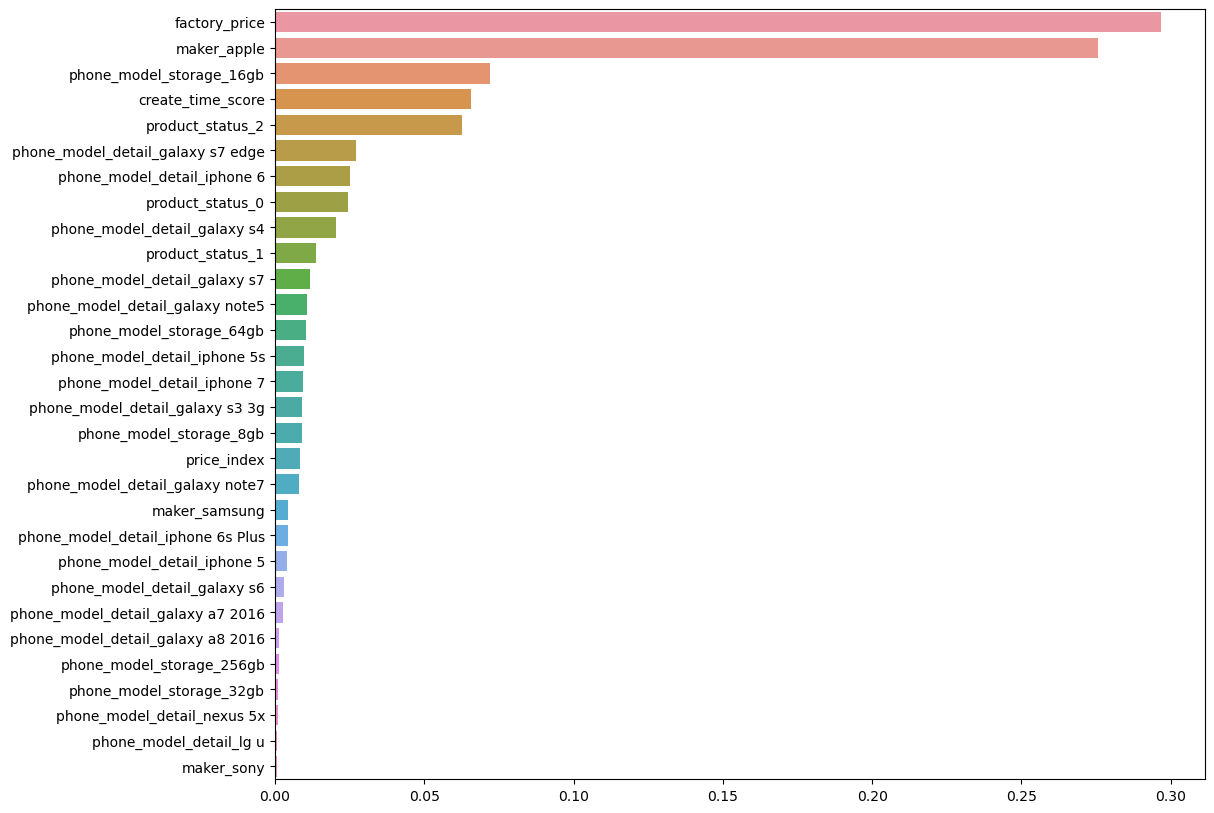

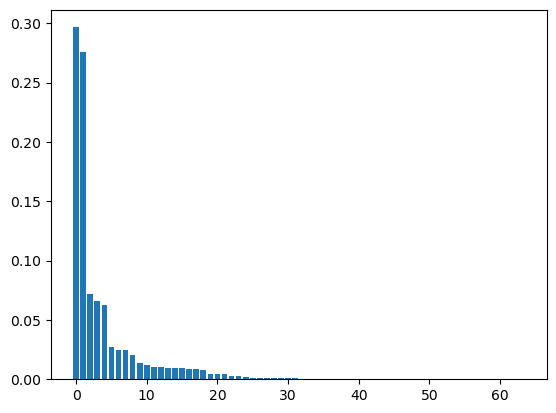

In [232]:
# 가격 예측 모델의 피처 중요도 plot을 출력(seaborn barplot)
importances = optimal_forest.best_estimator_.feature_importances_
importances = pd.Series(importances, index = x_train.columns)
importances_top = importances.sort_values(ascending = False)[:30]
plt.figure(figsize = (12, 10))
sns.barplot(x = importances_top.values, y = importances_top.index)
plt.show()

# 가격 예측 모델의 피처 중요도 plot을 출력(matplotlib bar)
importances = optimal_forest.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(x = range(len(indices)), height = importances[indices])
plt.show()

## 프로토타입: 얼마고(Almhago)

### [재사용을 위한 파일 저장하기]

In [233]:
import joblib

# 모델 예측을 위한 중간 오브젝트들을 각각 파일로 저장
with open("/Users/yanghaejun/Documents/이것이 데이터분석이다/이것이 데이터 분석이다 예제/data/used_mobile_pickles/model_to_factory_price_dict.pickle", "wb") as f:
    pickle.dump(model_to_factory_price_dict, f, pickle.HIGHEST_PROTOCOL)

with open("/Users/yanghaejun/Documents/이것이 데이터분석이다/이것이 데이터 분석이다 예제/data/used_mobile_pickles/col_to_index_dict.pickle", "wb") as f:
    pickle.dump(col_to_index_dict, f, pickle.HIGHEST_PROTOCOL)

with open("/Users/yanghaejun/Documents/이것이 데이터분석이다/이것이 데이터 분석이다 예제/data/used_mobile_pickles/common_words.pickle", "wb") as f:
    pickle.dump(common_words, f, pickle.HIGHEST_PROTOCOL)

with open("/Users/yanghaejun/Documents/이것이 데이터분석이다/이것이 데이터 분석이다 예제/data/used_mobile_pickles/init_vectorizer_vocabulary.pickle", "wb") as f:
    pickle.dump(index_vectorizer.vocabulary_, f, pickle.HIGHEST_PROTOCOL)

with open("/Users/yanghaejun/Documents/이것이 데이터분석이다/이것이 데이터 분석이다 예제/data/used_mobile_pickles/tfidf_vectorizer.pickle", "wb") as f:
    pickle.dump(tfidf_vetorizer, f, pickle.HIGHEST_PROTOCOL)

with open("/Users/yanghaejun/Documents/이것이 데이터분석이다/이것이 데이터 분석이다 예제/data/used_mobile_pickles/svm_classifier.pickle", "wb") as f:
    pickle.dump(svm, f, pickle.HIGHEST_PROTOCOL)

joblib.dump(optimal_forest.best_estimator_, "/Users/yanghaejun/Documents/이것이 데이터분석이다/이것이 데이터 분석이다 예제/data/used_mobile_pickles/rf_regressor.pickle", compress = 1)

['/Users/yanghaejun/Documents/이것이 데이터분석이다/이것이 데이터 분석이다 예제/data/used_mobile_pickles/rf_regressor.pickle']

### [예측에 필요한 파일 로드]

In [234]:
import pickle

with open("/Users/yanghaejun/Documents/이것이 데이터분석이다/이것이 데이터 분석이다 예제/data/used_mobile_pickles/model_to_factory_price_dict.pickle", 'rb') as f:
    model_to_factory_price_dict = pickle.load(f)
    
with open("/Users/yanghaejun/Documents/이것이 데이터분석이다/이것이 데이터 분석이다 예제/data/used_mobile_pickles/col_to_index_dict.pickle", 'rb') as f:
    col_to_index_dict = pickle.load(f)
    
with open("/Users/yanghaejun/Documents/이것이 데이터분석이다/이것이 데이터 분석이다 예제/data/used_mobile_pickles/common_words.pickle", 'rb') as f:
    common_words = pickle.load(f)

with open("/Users/yanghaejun/Documents/이것이 데이터분석이다/이것이 데이터 분석이다 예제/data/used_mobile_pickles/init_vectorizer_vocabulary.pickle", 'rb') as f:
    init_vectorizer_vocabulary = pickle.load(f)
    
with open("/Users/yanghaejun/Documents/이것이 데이터분석이다/이것이 데이터 분석이다 예제/data/used_mobile_pickles/tfidf_vectorizer.pickle", 'rb') as f:
    tfidf_vectorizer = pickle.load(f)
    
with open("/Users/yanghaejun/Documents/이것이 데이터분석이다/이것이 데이터 분석이다 예제/data/used_mobile_pickles/svm_classifier.pickle", 'rb') as f:
    svm_classifier = pickle.load(f)

rf_regressor = joblib.load("/Users/yanghaejun/Documents/이것이 데이터분석이다/이것이 데이터 분석이다 예제/data/used_mobile_pickles/rf_regressor.pickle")

In [266]:
import numpy as np

from konlpy.tag import Okt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor

class Almhago():
    def __init__(self, model_to_factory_price_dict, col_to_index_dict, common_words, init_vectorizer_vocabulary, tfidf_vetorizer, prd_status_classifier, price_regressor):
        self._model_to_factory_price_dict = model_to_factory_price_dict
        self._col_to_index_dict = col_to_index_dict
        self._common_words = common_words
        self._init_vectorizer_vocabulary = init_vectorizer_vocabulary
        self._index_vectorizer = self._init_index_vectorizer()  
        self._tfidf_vetorizer = tfidf_vetorizer
        self._prd_status_classifier = prd_status_classifier
        self._price_regressor = price_regressor
    
    def _get_common_words(self, x):
        tagger = Okt()
        poses = tagger.pos(x)
        return [pos[0] for pos in poses if pos[0] in self._common_words]
    
    def _text_cleaning(self, text):
        text = "".join(c for c in text if c.isalnum() or c in "+, ") # +를 제외한 특수문자 제거
        text = "".join(i for i in text if i.isdigit() == False) # 숫자가 아닌 문자들 제거
        return text
    
    def _init_index_vectorizer(self):
        word_index_vectorizer = CountVectorizer(tokenizer = lambda x: self._get_common_words(x))
        word_index_vectorizer.vocabulary_ = self._init_vectorizer_vocabulary
        return word_index_vectorizer
    
    def _get_factory_price(self, model_name, storage):
        return self._model_to_factory_price_dict[(model_name, storage)]
    
    def _get_prd_status(self, text):
        x = self._index_vectorizer.transform([self._text_cleaning(program_test_dict["text"])])
        x = self._tfidf_vetorizer.transform(x)
        return self._prd_status_classifier.predict(x)[0]
    
    def _print_almhago(self, model, price, prd_status):
        status = ""
        if prd_status == 0:
            status = "불량한"
        elif prd_status == 1:
            status = "양호한"
        else:
            status = "좋은"
        print("선택하신", model, "모델은", status, "상태입니다. Almhago 예상 가격은", str(int(price[0])), "원 입니다.")
    
    def predict(self, input_dict):
        feature = np.zeros(64)
        feature[self._col_to_index_dict["factory_price"]] = self._get_factory_price(input_dict["phone_model_detail"],
                                                                                    input_dict["phone_model_storage"])
        feature[self._col_to_index_dict["price_index"]] = input_dict["price_index"]
        feature[self._col_to_index_dict["create_time_score"]] = input_dict["create_time_score"]
        feature[self._col_to_index_dict["_".join(["maker", input_dict["maker"]])]] = 1
        feature[self._col_to_index_dict["_".join(["phone_model_detail", input_dict["phone_model_detail"]])]] = 1
        feature[self._col_to_index_dict["_".join(["phone_model_storage", input_dict["phone_model_storage"]])]] = 1
        feature[self._col_to_index_dict["_".join(["product_status", self._get_prd_status(input_dict["text"])])]] = 1

        # predict result
        predicted_price = self._price_regressor.predict([feature])
        self._print_almhago(input_dict["phone_model_detail"],
                            predicted_price,
                            self._get_prd_status(input_dict["text"]))

### [프로그램 테스트하기]

In [268]:
# 데이터의 가장 최근 시점인 2017년 4월을 기준으로 하기 위한 2개(price_index, create_time_score)의 피처를 정의
recent_price_index = 95.96
recent_create_time_score = 1.0

# 판매 가격을 예측하고자 하는 메이커, 기종, 용량을 입력하고, 상품의 상태를 나타내는 게시글을 입력
program_test_dict = {"maker": "apple",
                     "phone_model_detail": "iphone 6",
                     "phone_model_storage": "16gb",
                     "text": "아이폰6 스페이스그레이 16기가 10만원에 팔아요~ 직접거래 \
                     메인보드 세척 완료 한 침수 폰 입니다폰 안켜지는 상테이구요 고쳐서 쓰실분 가져가세요10만원에 팔아요 \
                     리퍼한지 얼마안되서 기스 이런거 하나도 없습니당~서울 강남 근처 직거래 가능하며택배거래도 가능해요",
                     "price_index": recent_price_index,
                     "create_time_score": recent_create_time_score}

# 정의한 피처를 파라미터로 하여 almhago 오브젝트를 생성
almhago = Almhago(model_to_factory_price_dict, col_to_index_dict, common_words, init_vectorizer_vocabulary, tfidf_vetorizer, svm_classifier, rf_regressor)

# 입력한 데이터로 판매 가격을 예측
almhago.predict(program_test_dict)

선택하신 iphone 6 모델은 좋은 상태입니다. Almhago 예상 가격은 152307 원 입니다.


/Users/yanghaejun/opt/anaconda3/envs/yang_conda/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
